In [1]:
import pylab
import pymoc
import xidplus
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from astropy.table import Table , join
from mocpy import MOC
from astropy.io import fits
from astropy import wcs



This notebook uses all the raw data from the XID+MIPS catalogue, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. The prior for XID+ is based on IRAC detected sources coming from SWIRE.

In [2]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_AKARI-SEP/data/holes_AKARI-SEP_irac_i1_O16_20180424.fits')
MOC=pymoc.MOC()
MOC.read('../../dmu2/dmu2_field_coverages/AKARI-SEP_MOC.fits')

In [3]:
Final=Sel_func.intersection(MOC)
Final.write('./data/testMoc.fits', overwrite=True)

## Read in XID+MIPS catalogue

In [4]:
XID_MIPS=Table.read('../dmu26_XID+MIPS_AKARI-SEP/data/dmu26_XID+MIPS_AKARI-SEP_cat_20190909.fits')

In [5]:
XID_MIPS[0:10]

help_id,RA,Dec,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24
,degrees,degrees,muJy,muJy,muJy,MJy / sr,MJy / sr,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,bool
HELP_J043429.210-545654.901,68.62170653034099,-54.94858348648463,80.42802,113.913284,49.530167,0.002208595,5.1016723e-06,1.0022461,680.5849,0.0,False
HELP_J043423.165-545626.480,68.59652177460741,-54.94068890812353,55.272625,84.64747,26.577156,-0.0012659467,4.908135e-06,1.0029539,1063.1514,0.001,False
HELP_J043416.087-545549.460,68.56703012381632,-54.93040549335446,10.661816,26.498941,2.7642608,-0.0012659467,4.908135e-06,0.99987483,1812.1738,0.0,True
HELP_J043424.834-545603.188,68.6034770052052,-54.934218985884876,27.242163,49.51786,9.029449,-0.0012659467,4.908135e-06,1.0007945,1698.6595,0.0,True
HELP_J043418.700-545621.169,68.57791531857676,-54.939213555347365,347.0184,376.3759,317.50742,-0.0012659467,4.908135e-06,1.001546,1373.7151,0.463,False
HELP_J043419.811-545645.131,68.58254550848122,-54.9458696905712,212.85785,241.46736,186.06978,-0.0012659467,4.908135e-06,0.99938905,2057.627,0.003,False
HELP_J043424.458-545559.494,68.60190668409987,-54.93319268410401,21.687775,45.13706,6.4285336,-0.0012659467,4.908135e-06,1.0014269,1901.6733,0.001,True
HELP_J043418.300-545543.616,68.5762489879036,-54.9287820921008,7.165051,17.531206,1.9945031,-0.0012659467,4.908135e-06,0.99980235,1944.1476,0.006,True


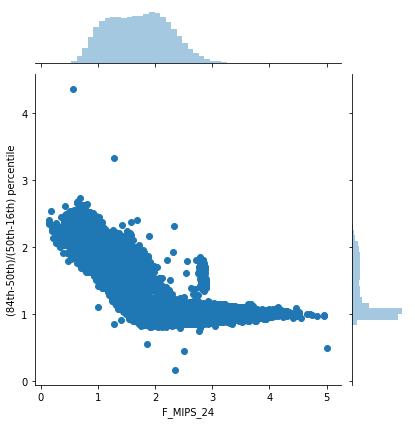

In [10]:
skew=(XID_MIPS['FErr_MIPS_24_u']-XID_MIPS['F_MIPS_24'])/(XID_MIPS['F_MIPS_24']-XID_MIPS['FErr_MIPS_24_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(XID_MIPS['F_MIPS_24']),y=skew ,kind='scatter')


The uncertianties become Gaussian by $\sim 30 \mathrm{\mu Jy}$

In [15]:
good=XID_MIPS['F_MIPS_24']>30

In [16]:
good.sum()

133942

## Read in Maps

In [17]:
im100fits='../../dmu18/dmu18_HELP-PACS-maps/data/AKARI-SEP_PACS100_v0.9.fits'#PACS 100 map
im160fits='../../dmu18/dmu18_HELP-PACS-maps/data/AKARI-SEP_PACS160_v0.9.fits'#PACS 160 map

#output folder
output_folder='./'

In [18]:
from astropy.io import fits
from astropy import wcs

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist['PRIMARY'].header
im100=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im100hdu=hdulist['IMAGE'].header

w_100 = wcs.WCS(hdulist['IMAGE'].header)
pixsize100=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim100=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2

hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist['PRIMARY'].header
im160=hdulist['IMAGE'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist['IMAGE'].header['BUNIT']='Jy/pix'
im160hdu=hdulist['IMAGE'].header

w_160 = wcs.WCS(hdulist['IMAGE'].header)
pixsize160=3600.0*np.abs(hdulist['IMAGE'].header['CDELT1']) #pixel size (in arcseconds)
nim160=hdulist['ERROR'].data*2.35045e-5*(np.abs(hdulist[1].header['CDELT1'])*3600)**2
hdulist.close()

In [19]:
np.shape(im100)

(2726, 4526)

## Read in PSF

In [20]:
pacs100_psf=fits.open('../../dmu18/dmu18_AKARI-SEP/data/dmu18_PACS_100_PSF_AKARI-SEP_20190125.fits')
pacs160_psf=fits.open('../../dmu18/dmu18_AKARI-SEP/data/dmu18_PACS_160_PSF_AKARI-SEP_20190125.fits')

print (pacs100_psf)
centre100=np.long((pacs100_psf[0].header['NAXIS1']-1)/2)
radius100=10
centre160=np.long((pacs160_psf[0].header['NAXIS1']-1)/2)
radius160=10

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[0].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[0].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map




In [21]:
print(pind160)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


In [1]:
import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[0].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1])
plt.colorbar()

## Set XID+ prior class

In [25]:
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=Final)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_AKARI-SEP_cat_20190909.fits',ID=XID_MIPS['help_id'][good])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=Final)
prior160.prior_cat(XID_MIPS['RA'][good],XID_MIPS['Dec'][good],'dmu26_XID+MIPS_AKARI-SEP_cat_20190909.fits',ID=XID_MIPS['help_id'][good])
prior160.prior_bkg(0.0,5)


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


In [28]:
priors=Master['priors']

In [29]:
priors

In [27]:
# Divide by 1000 so that units are mJy
prior100.set_prf(pacs100_psf[0].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[0].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [28]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior100.sra,prior100.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior100.sra,prior100.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior100,prior160],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 8325 tiles required for input catalogue and 19 large tiles


SystemExit: 